# Section 3

In [1]:
from model.model import *
import matplotlib.pyplot as plt
import torch
import numpy

### Reproducing Figure 5

In [2]:
def other_optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             stop_loss=0.015,
             drop_loss=0.02,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  # Replace trange with regular range
  for step in range(steps):
    step_lr = lr * lr_scale(step, steps)
    for group in opt.param_groups:
      group['lr'] = step_lr
    opt.zero_grad(set_to_none=True)
    batch = model.generate_batch(n_batch)
    out, load_balance_loss = model(batch)
    error = (model.importance*(batch.abs() - out)**2)
    reconstruction_loss = einops.reduce(error, 'b f -> f', 'mean').sum()
    
    loss = reconstruction_loss
    if load_balance_loss is not None:
      loss = loss + load_balance_loss
    
    loss.backward()
    opt.step()
  
    if hooks:
      hook_data = dict(model=model,
                       step=step, 
                       opt=opt,
                       error=error,
                       loss=loss,
                       reconstruction_loss=reconstruction_loss,
                       load_balance_loss=load_balance_loss,
                       lr=step_lr)
      for h in hooks:
        h(hook_data)
    if step % print_freq == 0 or (step + 1 == steps):
      print(f"Step {step}: loss={loss.item():.6f}, lr={step_lr:.6f}")
    

    if loss.item() < drop_loss:
      print(f"Dropping at step {step} with loss {loss.item():.6f}")
      lr = lr * 0.1
    if loss.item() < stop_loss:
      print(f"Stopping at step {step} with loss {loss.item():.6f}")
      return loss.item()
    
  return loss.item()

In [3]:
torch.random.manual_seed(42)
np.random.seed(42)

In [4]:
config = Config(
    n_features=2,
    n_hidden=1,
    n_experts=3,
    n_active_experts=1,
    load_balancing_loss=False,
)
model_base = MoEModel(config, device='cpu', feature_probability=torch.tensor(1), importance=torch.tensor(1))
nn.init.xavier_normal_(model_base.gate)
loss_base = other_optimize(model_base, n_batch=100, steps=10000, print_freq=2000, stop_loss=0.01, drop_loss=0.015)

model_zero = MoEModel(config, device='cpu', feature_probability=torch.tensor(1), importance=torch.tensor(1))
loss_zero = other_optimize(model_zero, n_batch=100, steps=10000, print_freq=2000, stop_loss=0.01, drop_loss=0.015)

Step 0: loss=0.515003, lr=0.001000
Step 2000: loss=0.028980, lr=0.001000
Step 4000: loss=0.026558, lr=0.001000
Step 6000: loss=0.030225, lr=0.001000
Step 8000: loss=0.028967, lr=0.001000
Step 9999: loss=0.027542, lr=0.001000
Step 0: loss=0.315504, lr=0.001000
Step 2000: loss=0.085763, lr=0.001000
Step 4000: loss=0.046964, lr=0.001000
Step 6000: loss=0.023046, lr=0.001000
Step 8000: loss=0.038427, lr=0.001000
Step 9999: loss=0.075491, lr=0.001000


In [8]:
def render_expert_specialization_multi(models_dict, resolution=100, save_path=None, losses_dict=None):
    """
    Render multiple expert specialization plots with LaTeX formatting for PDF/PGF export.
    
    Args:
        models_dict: Dictionary with {num_experts: model} mappings or {label: model}
        resolution: Number of points per dimension for the grid
        save_path: If provided, saves to {save_path}.pdf and {save_path}.pgf
        losses_dict: Optional dictionary with {label: loss_value} to display below each plot
    
    Returns:
        fig: matplotlib figure object
    """
    import torch.nn.functional as F
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    # Set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    # Create a grid of feature combinations
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Flatten for batch processing
    feature_grid = np.stack([X.flatten(), Y.flatten()], axis=1)
    feature_tensor = torch.tensor(feature_grid, dtype=torch.float32)
    
    # Calculate number of subplots needed
    n_models = len(models_dict)
    n_cols = min(3, n_models)  # Max 3 columns
    n_rows = (n_models + n_cols - 1) // n_cols
    
    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_models == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define colors for experts (using tab10 colormap)
    max_experts = max(
        int(getattr(getattr(model, "config", None), "n_experts", model.gate.shape[0]))
        for model in models_dict.values()
    )
    
    plot_idx = 0
    for label, model in sorted(models_dict.items()):
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[0] if n_models == 1 else axes[row, col]
        
        # Determine number of experts for this model
        num_experts = int(getattr(getattr(model, "config", None), "n_experts", model.gate.shape[0]))
        
        # Get expert assignments for all points
        with torch.no_grad():
            gate_scores = torch.einsum("bf,ef->be", feature_tensor, model.gate)
            gate_probs = F.softmax(gate_scores, dim=-1)
            _, top_expert_indices = torch.topk(gate_probs, k=1, dim=-1)
            expert_assignments = top_expert_indices.squeeze(-1)
        
        # Reshape back to grid
        expert_grid = expert_assignments.numpy().reshape(resolution, resolution)
        
        # Create discrete colormap for this model
        colors = plt.cm.tab10.colors[:num_experts]
        cmap = ListedColormap(colors)
        boundaries = np.arange(-0.5, num_experts + 0.5, 1)
        norm = BoundaryNorm(boundaries, cmap.N)
        
        # Create the plot
        im = ax.imshow(expert_grid, extent=[0, 1, 0, 1], origin='lower', 
                      cmap=cmap, norm=norm, interpolation='nearest')
        
        #ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Feature 1', fontsize=12)
        ax.set_ylabel('Feature 2', fontsize=12)
        
        # Add colorbar with expert labels
        cbar = plt.colorbar(im, ax=ax, ticks=range(num_experts), boundaries=boundaries)
        #cbar.set_label('Expert ID', fontsize=10)
        cbar.set_ticklabels([f'Expert {i}' for i in range(num_experts)])
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # Add loss text below this subplot if provided
        if losses_dict is not None and label in losses_dict:
            loss = losses_dict[label]
            ax.text(0.5, -0.25, f'\\textbf{{Loss: {loss:.3f}}}',
                   transform=ax.transAxes, ha='center', va='top',
                   fontsize=16, color='black')
        
        plot_idx += 1
    
    # Hide any unused subplots
    for idx in range(plot_idx, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    # Adjust layout with extra space at bottom if losses are provided
    if losses_dict is not None:
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    else:
        plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight', dpi=300)
        plt.savefig(f"{save_path}.pgf", bbox_inches='tight')
        print(f"Saved to {save_path}.pdf and {save_path}.pgf")
    
    plt.show()
    
    #return fig

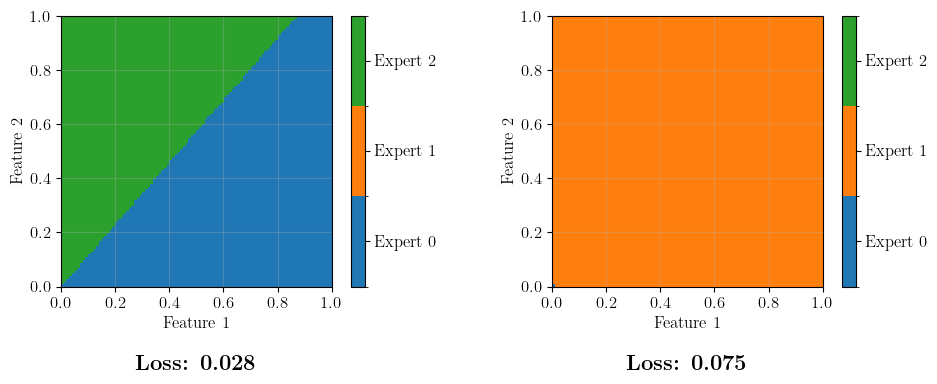

In [9]:
losses = {"1": loss_base, "2": loss_zero}
render_expert_specialization_multi({"1": model_base, "2": model_zero}, losses_dict=losses)

### Reproducing Figure 6


In [10]:
from model.model import *
import matplotlib.pyplot as plt
import torch
import numpy

np.random.seed(41)
torch.manual_seed(41)
DEVICE = "cpu"

In [12]:
config_fig6 = Config(
    n_features = 20,
    n_hidden = 5,
    n_experts = 4,
    n_active_experts = 1,
    load_balancing_loss = False,
)

model_6a = MoEModel(
    config=config_fig6,
    device=DEVICE,
    importance = 0.7**torch.from_numpy(np.arange(config_fig6.n_features)),
    feature_probability = torch.tensor(0.09)
)

model_6b = MoEModel(
    config=config_fig6,
    device=DEVICE,
    importance = 0.6**torch.from_numpy(np.arange(config_fig6.n_features)),
    feature_probability = torch.tensor(0.20)
)

model_6c = MoEModel(
    config=config_fig6,
    device=DEVICE,
    importance = 0.7**torch.from_numpy(np.random.choice(config_fig6.n_features, config_fig6.n_features, replace=False)),
    feature_probability = torch.tensor(0.1)
)


# Initialize gate matrix to the diagonal (for 6a)
with torch.no_grad():
    model_6a.gate.fill_diagonal_(1)

# Initialize gate matrix to increments of 5 (for 6b)
indices = np.arange(model_6b.gate.shape[1]) # NOT RANDOM ON THIS ONE
indices = torch.from_numpy(indices.reshape(model_6b.gate.shape[0], -1))
print(indices)
print(model_6b.importance)
with torch.no_grad():
    for i in range(model_6b.gate.shape[0]):
        model_6c.gate[i, indices[i]] = 1

# Random k-hot initialize the gate matrix (for 6c)
indices = np.random.choice(model_6c.gate.shape[1], size=int(model_6c.gate.shape[0]*5), replace=False)
indices = torch.from_numpy(indices.reshape(model_6c.gate.shape[0], -1))
with torch.no_grad():
    for i in range(model_6c.gate.shape[0]):
        model_6c.gate[i, indices[i]] = 1


tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
tensor([1.0000e+00, 6.0000e-01, 3.6000e-01, 2.1600e-01, 1.2960e-01, 7.7760e-02,
        4.6656e-02, 2.7994e-02, 1.6796e-02, 1.0078e-02, 6.0466e-03, 3.6280e-03,
        2.1768e-03, 1.3061e-03, 7.8364e-04, 4.7019e-04, 2.8211e-04, 1.6927e-04,
        1.0156e-04, 6.0936e-05])


In [13]:
print(f"Training first model...")
optimize(model_6a, n_batch=1024, steps=10000, print_freq=1000)
print(f"Training second model...")
optimize(model_6b, n_batch=1024, steps=10000, print_freq=1000)
print(f"Training last model...")
optimize(model_6c, n_batch=1024, steps=10000, print_freq=1000)

Training first model...
Step 0: loss=0.083293, lr=0.001000
Step 1000: loss=0.004845, lr=0.001000
Step 2000: loss=0.004203, lr=0.001000
Step 3000: loss=0.004008, lr=0.001000
Step 4000: loss=0.004081, lr=0.001000
Step 5000: loss=0.003541, lr=0.001000
Step 6000: loss=0.003439, lr=0.001000
Step 7000: loss=0.004583, lr=0.001000
Step 8000: loss=0.004064, lr=0.001000
Step 9000: loss=0.003047, lr=0.001000
Step 9999: loss=0.003269, lr=0.001000
Training second model...
Step 0: loss=0.136410, lr=0.001000
Step 1000: loss=0.008388, lr=0.001000
Step 2000: loss=0.009054, lr=0.001000
Step 3000: loss=0.010330, lr=0.001000
Step 4000: loss=0.009505, lr=0.001000
Step 5000: loss=0.007183, lr=0.001000
Step 6000: loss=0.007636, lr=0.001000
Step 7000: loss=0.007968, lr=0.001000
Step 8000: loss=0.008774, lr=0.001000
Step 9000: loss=0.009502, lr=0.001000
Step 9999: loss=0.008301, lr=0.001000
Training last model...
Step 0: loss=0.099645, lr=0.001000
Step 1000: loss=0.005473, lr=0.001000
Step 2000: loss=0.006328,

In [14]:
def render_features_bar(model, save_path=None):
    """Render bar plots showing feature norms colored by polysemanticity"""
    cfg = model.config
    # expert weights
    W_exp = model.W_experts.detach()
    W_norm = W_exp / (1e-5 + torch.linalg.norm(W_exp, 2, dim=2, keepdim=True))

    interference = torch.einsum('ifh,igh->ifg', W_norm, W_exp) # (n_experts, n_features, n_features)
    interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0 # set diagonal to 0

    polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
    norms = torch.linalg.norm(W_exp, 2, dim=-1).cpu()

    x = torch.arange(cfg.n_features)
    
    # set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    fig, axes = plt.subplots(cfg.n_experts, 1, figsize=(6, 4 * cfg.n_experts))
    if cfg.n_experts == 1:
        axes = [axes]
    
    for expert_idx in range(cfg.n_experts):
        ax = axes[expert_idx]
        
        # Create bar plot with color mapping and narrower bars
        bars = ax.bar(x, norms[expert_idx], 
                     color=plt.cm.viridis(polysemanticity[expert_idx] / polysemanticity[expert_idx].max()),
                     width=0.6)
        
        # Add colorbar using ScalarMappable
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=polysemanticity[expert_idx].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Superposition')
        
        # Add vertical line at n_hidden boundary
        ax.axvline(x=(cfg.n_hidden-0.5), color='red', linestyle='--', alpha=0.7, linewidth=1)
        
        ax.set_title(f'Expert {expert_idx}')
        #ax.set_xlabel('Features $\\rightarrow$')
        #ax.set_ylabel('Norm $||W_i||$')
        ax.grid(True, alpha=0.3)
        
        # Set x-axis ticks to go from 0 to 5 to 10 to 15
        ax.set_xticks([0, 5, 10, 15])
        
        # Set x-axis limits to reduce horizontal width
        ax.set_xlim(-0.5, cfg.n_features - 0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_bar.pdf", bbox_inches='tight')
        plt.savefig(f"{save_path}_bar.pgf", bbox_inches='tight')
    
    plt.show()
    #return fig

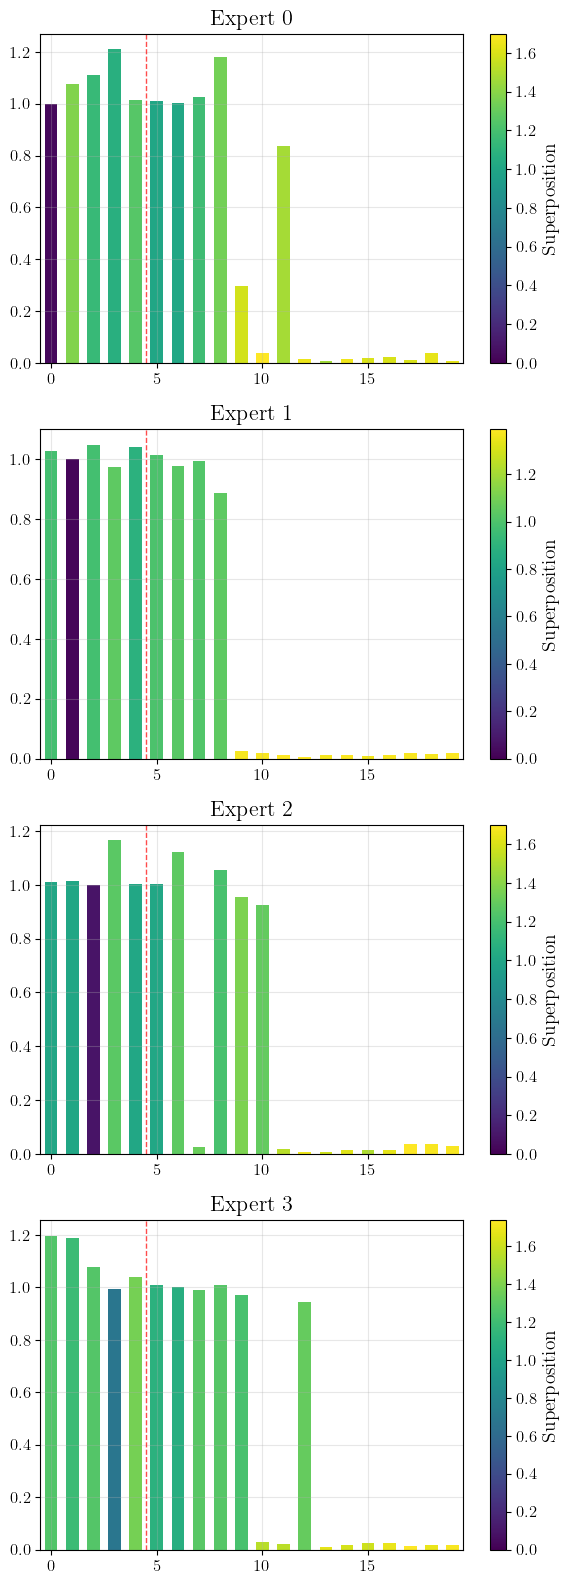

In [16]:
render_features_bar(model_6a)

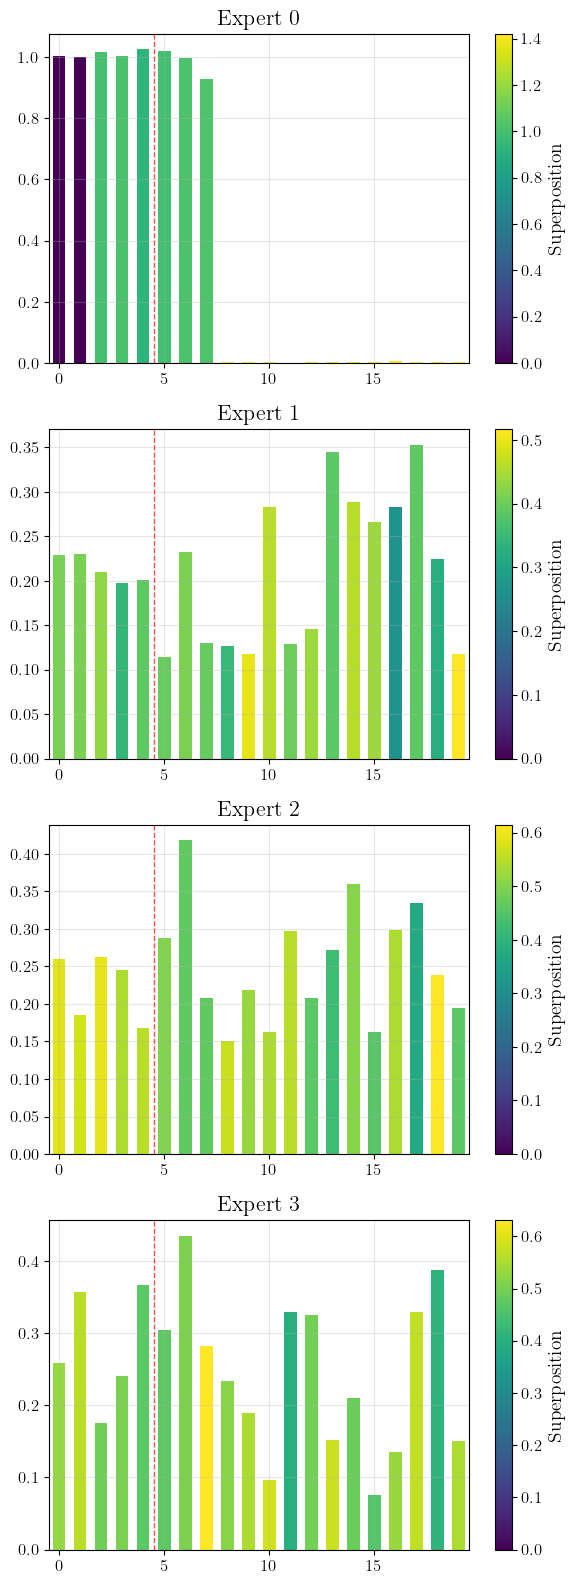

In [17]:
render_features_bar(model_6b)

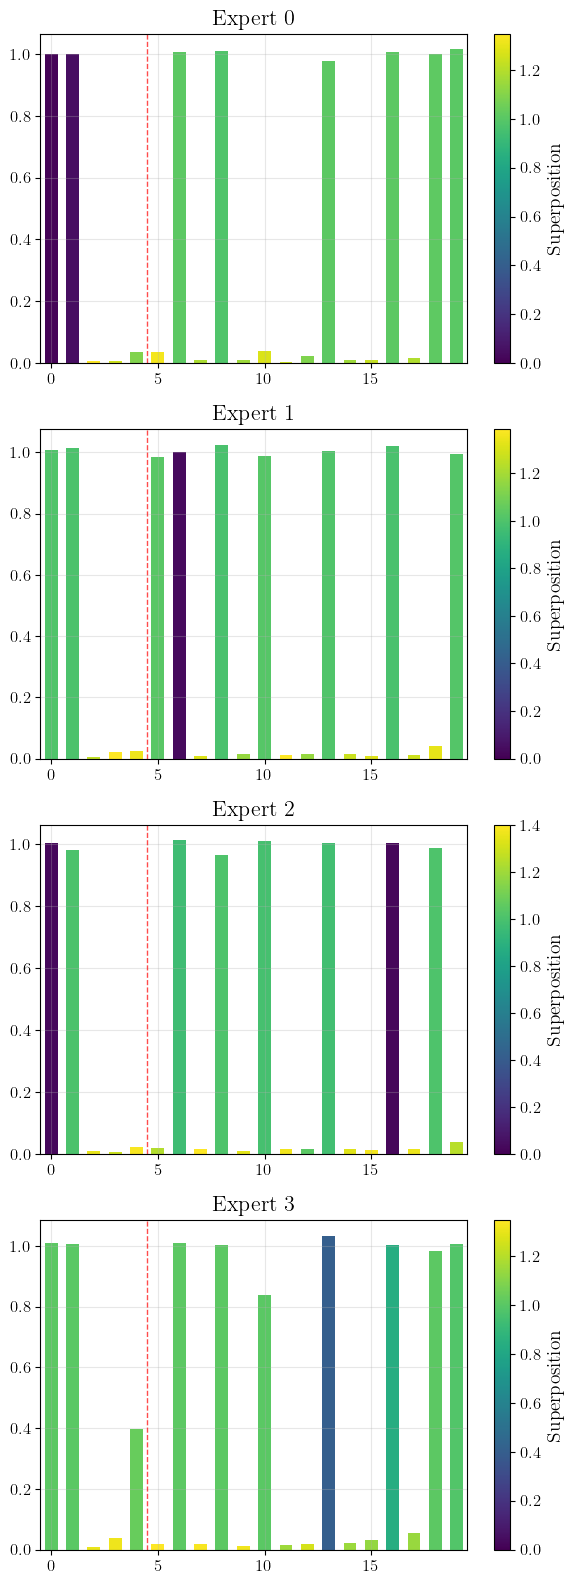

tensor([[14, 18,  1,  8, 12],
        [ 9, 10,  6,  2,  5],
        [ 7, 11,  0,  3, 16],
        [19, 17,  4, 15, 13]])
tensor([1.0000, 0.3430, 0.0016, 0.0023, 0.0282, 0.0404, 0.7000, 0.0033, 0.1176,
        0.0047, 0.0576, 0.0011, 0.0198, 0.2401, 0.0097, 0.0068, 0.4900, 0.0138,
        0.0824, 0.1681])


In [18]:
render_features_bar(model_6c)
print(indices)
print(model_6c.importance)

### Reproducing Table 1

In [19]:
from model.model import optimize_vectorized
from helpers.helpers import my_gate_init, save_initial_weights
from functools import partial
import os
cfg = Config(
    n_features = 100,
    n_hidden = 10,
    n_experts = 10,
    n_active_experts = 1,
    load_balancing_loss = False,
)
N = 200
DEVICE = "mps" if torch.mps.is_available() else "cpu"

feature_prob = torch.tensor(0.1).to(DEVICE)
importance = 0.9**torch.from_numpy(np.random.choice(cfg.n_features, cfg.n_features, replace=False)).to(DEVICE)

feature_probs = [feature_prob for _ in range(N)]
configs = [cfg for _ in range(N)]
importances = [importance for _ in range(N)]

os.makedirs("models", exist_ok=True)

# 2) Train vectorized
final_losses, stacked_params = optimize_vectorized(
    configs,
    feature_probs,
    importances,
    device=DEVICE,
    n_batch=1024,
    steps=10000,
    lr=1e-3,
    print_freq=1000,
    init_fn=my_gate_init,
    on_initialized=partial(save_initial_weights, save_path="models/hundred_feats_vectorized_init")
)
print("Per-model losses:", final_losses.tolist())

print(stacked_params.keys())
gate = stacked_params["gate"]
print(gate.shape)
snapshot = {
    "configs": configs,
    "feature_probs": [fp if torch.is_tensor(fp) else torch.tensor(fp) for fp in feature_probs],
    "importances": [imp.detach().cpu() for imp in importances],
    "stacked_params": {k: v.detach().cpu().clone() for k, v in stacked_params.items()},
}
torch.save(snapshot, "models/post_training_vectorized_weights.pt")

N LOCAL: 200
tensor([[ 1.0549e-01, -7.2471e-02, -4.9042e-02,  1.0251e-01, -1.4621e-01,
          1.5537e-01,  9.7214e-02, -1.8704e-01, -3.9594e-02, -3.2266e-01,
          1.0676e-01,  1.2634e-01,  8.0987e-02, -2.9833e-02,  6.1461e-02,
         -1.3871e-01,  5.0478e-02,  2.2058e-01, -1.0401e-01, -1.4920e-01,
          2.0507e-03, -3.7603e-02, -3.0940e-01, -1.0736e-01,  2.2476e-01,
          8.7042e-02, -1.9680e-01,  1.7267e-03, -1.4269e-01, -4.5591e-02,
         -8.3151e-02, -1.2666e-01, -5.5062e-02,  1.0782e-01,  1.2569e-01,
         -2.1645e-01, -7.0221e-02,  1.6781e-01,  1.1631e-01, -1.8324e-01,
          4.2378e-02, -6.0316e-02,  9.6499e-02, -3.2109e-01,  1.6699e-02,
         -1.2288e-01,  2.3795e-02, -1.1785e-02,  2.0919e-01, -1.0919e-01,
          8.6469e-02, -6.5041e-02, -2.3356e-01,  1.3331e-01,  9.2947e-02,
          8.4479e-03,  9.9247e-02,  3.0743e-01, -4.8562e-03, -3.5211e-02,
          2.7869e-02, -2.2764e-02,  4.7631e-02, -7.6083e-02,  1.7092e-01,
         -2.4538e-01,  1.

In [20]:
vectorized_models = torch.load("models/post_training_vectorized_weights.pt", weights_only=False)
stacked_params = vectorized_models['stacked_params']
W_exp = stacked_params['W_experts']
W_norm = W_exp / (1e-5 + torch.linalg.norm(W_exp, 2, dim=3, keepdim=True))

interference = torch.einsum('...ifh,...igh->...ifg', W_norm, W_exp) # (n_experts, n_features, n_features)
interference[:, :, torch.arange(100), torch.arange(100)] = 0 # set diagonal to 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

mask = polysemanticity < 0.2
polysemanticity[~mask] = float('inf')
#new_poly = polysemanticity.flatten(start_dim=0, end_dim=1)
counts = mask.sum(dim=2)#.flatten(start_dim=0, end_dim=1)

xavier_mono_feats = []
khot_mono_feats = []
for i in range(100):
    expert_list = []
    for j in range(10):
        expert_feat_count = counts[i][j]
        if expert_feat_count > 0:
            expert_list.append((j, polysemanticity[i][j].topk(expert_feat_count, largest=False)[1]))
    print(expert_list)
    xavier_mono_feats.append(expert_list)
print("Moving from xavier init to khot init")
for i in range(100, 200):
    expert_list = []
    for j in range(10):
        expert_feat_count = counts[i][j]
        if expert_feat_count > 0:
            expert_list.append((j, polysemanticity[i][j].topk(expert_feat_count, largest=False)[1]))
    print(expert_list)
    khot_mono_feats.append(expert_list)   

print(xavier_mono_feats)
print(khot_mono_feats)

[(0, tensor([87])), (1, tensor([ 6, 20])), (2, tensor([85])), (3, tensor([81])), (4, tensor([24])), (5, tensor([20])), (6, tensor([85])), (7, tensor([24])), (9, tensor([85, 65]))]
[(0, tensor([85])), (1, tensor([83])), (2, tensor([74])), (5, tensor([39])), (7, tensor([20]))]
[(0, tensor([87, 85, 39])), (3, tensor([87])), (4, tensor([39])), (5, tensor([87])), (6, tensor([74])), (9, tensor([26]))]
[(0, tensor([74, 88])), (3, tensor([83])), (4, tensor([87, 85])), (7, tensor([87]))]
[(0, tensor([65])), (1, tensor([81])), (2, tensor([85])), (6, tensor([48])), (8, tensor([87, 39])), (9, tensor([74,  6]))]
[(0, tensor([87, 81])), (2, tensor([24])), (3, tensor([85])), (4, tensor([87, 39])), (8, tensor([65])), (9, tensor([85]))]
[(2, tensor([85])), (6, tensor([65])), (8, tensor([74]))]
[(1, tensor([39, 24])), (2, tensor([74])), (3, tensor([26])), (4, tensor([85])), (7, tensor([24])), (8, tensor([87, 20])), (9, tensor([88]))]
[(0, tensor([85])), (3, tensor([24])), (5, tensor([39])), (6, tensor([

In [34]:
batch_gen_func = MoEModel.generate_batch

def dataset_conditional_batch_generation(model, info, n_batch=1024, clamp_value: Optional[float] = None):
    expert_id, feature_indices = info
    """Fix certain features and sample the other features according to config statistics"""
    # print(f"Using statistics from model. Feature probability: {model.feature_probability}")
    print(f'Expert {expert_id} monosemantically represents features: {feature_indices}')
    batch = batch_gen_func(model, n_batch)
    if clamp_value is not None:
        batch[:, feature_indices] = clamp_value
    else:
        # Sample uniformly between 0.5 and 1
        clamps = torch.rand(batch.shape[0], 1) #* 0.5 + 0.5
        batch[:, feature_indices] = clamps
    #print(batch)
    return batch
    # print(batch.shape)

def batch_only_feature_active_gen(model, info, n_batch=1024, clamp_value: Optional[float] = None):
    expert_id, feature_indices = info
    """Fix certain features and sample the other features according to config statistics"""
    # print(f"Using statistics from model. Feature probability: {model.feature_probability}")
    print(f'Expert {expert_id} monosemantically represents features: {feature_indices}')
    batch = torch.zeros(n_batch, model.config.n_features)
    clamps = torch.rand(batch.shape[0], 1)
    batch[:, feature_indices] = clamps
    return batch


In [55]:
#COLUMN_CHOICE = "unchanged"
COLUMN_CHOICE = "active (clamped to 1)"
#COLUMN_CHOICE = "only feature active (all other features=0)"

In [56]:
gates = stacked_params['gate']
xav_mean_usage_counts = {1: [], 2: [], 3: [], 4: [],}
khot_mean_usage_counts = {1: [], 2: [], 3: [], 4: [], 5: [],}
xav_medians = []
khot_medians = []
model = MoEModel(config=vectorized_models['configs'][0], device="cpu") # simply used for generating the input batch

batch_gen_functions = {
    "unchanged": batch_gen_func,
    "active (clamped to 1)": dataset_conditional_batch_generation,
    "only feature active (all other features=0)": batch_only_feature_active_gen
}

for i in range(len(xavier_mono_feats)):
    for j in range(len(xavier_mono_feats[i])):
        gate = gates[i]
        func = batch_gen_functions[COLUMN_CHOICE]
        if COLUMN_CHOICE == "unchanged":
            batch = func(model, n_batch=8192)
        else:
            batch = func(model, xavier_mono_feats[i][j], n_batch=8192, clamp_value=1.0)
        gate_scores = torch.einsum("...f,ef->...e", batch, gate)
        gate_probs = F.softmax(gate_scores, dim=-1)
        gate_probs_topk = gate_probs.topk(1, dim=-1)

        values, indices = gate_probs_topk
        counts = indices.flatten().bincount()
        if counts.shape[0] < model.config.n_experts:
            counts = torch.cat([counts, torch.zeros(model.config.n_experts - counts.shape[0])])

        counts = counts / counts.sum()

        xav_medians.append(torch.median(counts).item())

        num_feats = xavier_mono_feats[i][j][1].shape[0]
        exp_num = xavier_mono_feats[i][j][0]
        xav_mean_usage_counts[num_feats].append(counts[exp_num].detach().item())

print("ENDING XAV, STARTING KHOT")

for i in range(len(khot_mono_feats)):
    for j in range(len(khot_mono_feats[i])):
        gate = gates[i+100]
        func = batch_gen_functions[COLUMN_CHOICE]
        if COLUMN_CHOICE == "unchanged":
            batch = func(model, n_batch=8192)
        else:
            batch = func(model, khot_mono_feats[i][j], n_batch=8192, clamp_value=1.0)
        gate_scores = torch.einsum("...f,ef->...e", batch, gate)
        gate_probs = F.softmax(gate_scores, dim=-1)
        gate_probs_topk = gate_probs.topk(1, dim=-1)

        values, indices = gate_probs_topk
        counts = indices.flatten().bincount()
        if counts.shape[0] < model.config.n_experts:
            counts = torch.cat([counts, torch.zeros(model.config.n_experts - counts.shape[0])])

        counts = counts / counts.sum()


        khot_medians.append(torch.median(counts).item())

        num_feats = khot_mono_feats[i][j][1].shape[0]
        exp_num = khot_mono_feats[i][j][0]
        khot_mean_usage_counts[num_feats].append(counts[exp_num].detach().item())

Expert 0 monosemantically represents features: tensor([87])
Expert 1 monosemantically represents features: tensor([ 6, 20])
Expert 2 monosemantically represents features: tensor([85])
Expert 3 monosemantically represents features: tensor([81])
Expert 4 monosemantically represents features: tensor([24])
Expert 5 monosemantically represents features: tensor([20])
Expert 6 monosemantically represents features: tensor([85])
Expert 7 monosemantically represents features: tensor([24])
Expert 9 monosemantically represents features: tensor([85, 65])
Expert 0 monosemantically represents features: tensor([85])
Expert 1 monosemantically represents features: tensor([83])
Expert 2 monosemantically represents features: tensor([74])
Expert 5 monosemantically represents features: tensor([39])
Expert 7 monosemantically represents features: tensor([20])
Expert 0 monosemantically represents features: tensor([87, 85, 39])
Expert 3 monosemantically represents features: tensor([87])
Expert 4 monosemanticall

In [57]:
gates = stacked_params['gate']

print("Xavier Initialization Scheme\n")
print(f"Number of experts with 1 monosemantic feature: {len(xav_mean_usage_counts[1])}")
print(f"Number of experts with 2 monosemantic feature: {len(xav_mean_usage_counts[2])}")
print(f"Number of experts with 3 monosemantic feature: {len(xav_mean_usage_counts[3])}")
print(f"Number of experts with 4 monosemantic feature: {len(xav_mean_usage_counts[4])}\n")

mean_usage_one = sum(xav_mean_usage_counts[1]) / len(xav_mean_usage_counts[1])
mean_usage_two = sum(xav_mean_usage_counts[2]) / len(xav_mean_usage_counts[2])
mean_usage_three = sum(xav_mean_usage_counts[3]) / len(xav_mean_usage_counts[3])
mean_usage_four = sum(xav_mean_usage_counts[4]) / len(xav_mean_usage_counts[4])
#print(f"Average usage of experts with 1,2,3,4 monosemantic features, when that feature is {COLUMN_CHOICE}:")
print(f"\nAverage usage of experts w/ 1 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_one}")
print(f"Average usage of experts w/ 2 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_two}")
print(f"Average usage of experts w/ 3 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_three}")
print(f"Average usage of experts w/ 4 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_four}")
#print(mean_usage_one, mean_usage_two, mean_usage_three, mean_usage_four)

xav_mean_med = sum(xav_medians) / len(xav_medians)
xav_mean_std = torch.std(torch.as_tensor(xav_medians)).item()
#print(xav_mean_med, xav_mean_std)

print("\nK-Hot Initialization Scheme\n")
print(f"Number of experts with 1 monosemantic feature: {len(khot_mean_usage_counts[1])}")
print(f"Number of experts with 2 monosemantic feature: {len(khot_mean_usage_counts[2])}")
print(f"Number of experts with 3 monosemantic feature: {len(khot_mean_usage_counts[3])}")
print(f"Number of experts with 4 monosemantic feature: {len(khot_mean_usage_counts[4])}")
mean_usage_one = sum(khot_mean_usage_counts[1]) / len(khot_mean_usage_counts[1])
mean_usage_two = sum(khot_mean_usage_counts[2]) / len(khot_mean_usage_counts[2])
mean_usage_three = sum(khot_mean_usage_counts[3]) / len(khot_mean_usage_counts[3])
mean_usage_four = sum(khot_mean_usage_counts[4]) / len(khot_mean_usage_counts[4])
mean_usage_five = sum(khot_mean_usage_counts[5]) / len(khot_mean_usage_counts[5]) if len(khot_mean_usage_counts[5]) else 0.0
#print(f"Average usage of experts with 1,2,3,4 monosemantic features, when that feature is {COLUMN_CHOICE}:")
print(f"\nAverage usage of experts w/ 1 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_one}")
print(f"Average usage of experts w/ 2 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_two}")
print(f"Average usage of experts w/ 3 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_three}")
print(f"Average usage of experts w/ 4 monosemantic features, when that feature(s) is {COLUMN_CHOICE}:\n {mean_usage_four}")
#print(mean_usage_one, mean_usage_two, mean_usage_three, mean_usage_four, mean_usage_five)

khot_mean_med = sum(khot_medians) / len(khot_medians)
khot_mean_std = torch.std(torch.as_tensor(khot_medians)).item()
#print(khot_mean_med, khot_mean_std)

Xavier Initialization Scheme

Number of experts with 1 monosemantic feature: 420
Number of experts with 2 monosemantic feature: 124
Number of experts with 3 monosemantic feature: 14
Number of experts with 4 monosemantic feature: 1


Average usage of experts w/ 1 monosemantic features, when that feature(s) is active (clamped to 1):
 0.12006923130580358
Average usage of experts w/ 2 monosemantic features, when that feature(s) is active (clamped to 1):
 0.06920697612147178
Average usage of experts w/ 3 monosemantic features, when that feature(s) is active (clamped to 1):
 0.06759207589285714
Average usage of experts w/ 4 monosemantic features, when that feature(s) is active (clamped to 1):
 0.0

K-Hot Initialization Scheme

Number of experts with 1 monosemantic feature: 435
Number of experts with 2 monosemantic feature: 215
Number of experts with 3 monosemantic feature: 56
Number of experts with 4 monosemantic feature: 3

Average usage of experts w/ 1 monosemantic features, when that feat